# Basic Text Processing & TSNE Visualization on Amazon Fine Food Reviews Data


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Required Libraries

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading Data

In [ ]:
# using the SQLite Table to read data.
con = sqlite3.connect(F'/content/drive/MyDrive/Aazon_Review_Data/database.sqlite') 

#filtering only positive and negative reviews i.e. ignoring neutral reviews with Score = 3
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)
print(data.shape)
data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#sampling 20k reviews
df = data.sample(n = 20000, random_state = 1).reset_index(drop = True)
df.shape

(20000, 10)

In [ ]:
#proprtion of review scores
df.Score.value_counts()

5    13768
4     3054
1     1941
2     1237
Name: Score, dtype: int64

In [ ]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
df['Score'] = np.where(df['Score'] > 3, 1, 0)
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,87501,B001D0GV6I,AXL5GJLYKKLMX,"KCBrad ""KCBrad""",0,0,1,1272672000,Great flavor,This is one of my favorite flavors. This Fren...
1,476117,B001EQ4EHE,A261ERFPYHP556,"Vinsanity18 ""Vince""",1,1,1,1274054400,Tastes Great,I bought this for my girl friend that recently...
2,225032,B001LNTY70,A2GH0L50430WJF,E. Reynolds,0,0,1,1336262400,Mostly lime!,Not a big fan of chili actually... so these al...


## Data Cleaning

In [ ]:
#Sorting data according to ProductId in ascending order
df.sort_values('ProductId', axis = 0, ascending = True, inplace = True, kind = 'quicksort', na_position = 'last')

In [ ]:
#Deduplication of entries
df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep ='first', inplace = True)
df.shape

(19267, 10)

<b>Insight:-</b> In some rows, value of HelpfulnessNumerator can be greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions.
It is not possible that more number of people found these reviews useful compared to number of people who have seen this review.

In [ ]:
#removing records with HelpfulnessNumerator > HelpfulnessDenominator
df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]
df.shape

(19266, 10)

In [ ]:
#selecting required columns
df = df[['Text', 'Score']]
df.head()

,Text,Score
5857,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,1
17532,"We have used Pro-Treat Beef Liver, Freeze Drie...",1
11598,My dog trainer recommended this to our obedien...,1
11222,This is one product that my welsh terrier can ...,1
11121,Though they might be a bit pricey for just the...,1


In [ ]:
#Distribution of +ve and -ve Reviews
df['Score'].value_counts()

1    16201
0     3065
Name: Score, dtype: int64

## Text Preprocessing

### Converting to Lower Case

In [ ]:
#converting text reviews to lower case
df['Text'] = df['Text'].str.lower()
df['Text'].head()

5857     title: chicken soup with rice<br />author: mau...
17532    we have used pro-treat beef liver, freeze drie...
11598    my dog trainer recommended this to our obedien...
11222    this is one product that my welsh terrier can ...
11121    though they might be a bit pricey for just the...
Name: Text, dtype: object

### Remove URLS

In [ ]:
#remove urls from text reviews
df['Text'] = df['Text'].apply(lambda x : re.sub('http[s]?://\S+', ' ', x))
df['Text'].head()

5857     title: chicken soup with rice<br />author: mau...
17532    we have used pro-treat beef liver, freeze drie...
11598    my dog trainer recommended this to our obedien...
11222    this is one product that my welsh terrier can ...
11121    though they might be a bit pricey for just the...
Name: Text, dtype: object

### Remove HTML Tags

In [ ]:
#removing html tags
df['Text'] = df['Text'].apply(lambda x: re.sub('<[^<]+?>', ' ', x))
df['Text'][5857]

'title: chicken soup with rice author: maurice sendak reviewer: josh grossman, colonel {r}, u.s.a.r., m.c., m.d., facp rural physician/author/educator-mentor u.s.m.l.e. step 3... >who would believe that i have memorized this book? >who would believe that i can recite any month in any order? >who would believe that i read my copy to tatters while reading to my children now professional adults? >who would believe that my grandchildren read their copy to tatters? i can be confident that generations of children will enjoy "chicken soup with rice" bravo! thank you! respectfully submitted...'

### Remove Alphanumeric Words

In [ ]:
#remove words with numbers python
df['Text'] = df['Text'].apply(lambda x: re.sub('\S*\d\S*', ' ', x))
df['Text'][5857]

'title: chicken soup with rice author: maurice sendak reviewer: josh grossman, colonel {r}, u.s.a.r., m.c., m.d., facp rural physician/author/educator-mentor u.s.m.l.e. step   >who would believe that i have memorized this book? >who would believe that i can recite any month in any order? >who would believe that i read my copy to tatters while reading to my children now professional adults? >who would believe that my grandchildren read their copy to tatters? i can be confident that generations of children will enjoy "chicken soup with rice" bravo! thank you! respectfully submitted...'

### Remove Special Characters

In [ ]:
#remove special character
df['Text'] = df['Text'].apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
df['Text'][5857]

'title chicken soup with rice author maurice sendak reviewer josh grossman colonel r u s a r m c m d facp rural physician author educator mentor u s m l e step who would believe that i have memorized this book who would believe that i can recite any month in any order who would believe that i read my copy to tatters while reading to my children now professional adults who would believe that my grandchildren read their copy to tatters i can be confident that generations of children will enjoy chicken soup with rice bravo thank you respectfully submitted '

### Remove Single Length Words

In [ ]:
#removing single character words
df['Text'] = df['Text'].apply(lambda x: re.sub(r'\b[a-zA-Z]\b', ' ', x))
df['Text'][5857]

'title chicken soup with rice author maurice sendak reviewer josh grossman colonel                   facp rural physician author educator mentor           step who would believe that   have memorized this book who would believe that   can recite any month in any order who would believe that   read my copy to tatters while reading to my children now professional adults who would believe that my grandchildren read their copy to tatters   can be confident that generations of children will enjoy chicken soup with rice bravo thank you respectfully submitted '

### Remove Multiple White Spaces

In [ ]:
#replace multi white spaces
df['Text'] = df['Text'].apply(lambda x: re.sub('\s{2,}', ' ', x))
df['Text'][5857]

'title chicken soup with rice author maurice sendak reviewer josh grossman colonel facp rural physician author educator mentor step who would believe that have memorized this book who would believe that can recite any month in any order who would believe that read my copy to tatters while reading to my children now professional adults who would believe that my grandchildren read their copy to tatters can be confident that generations of children will enjoy chicken soup with rice bravo thank you respectfully submitted '

#### Remove Spaces from Start & End of Text

In [ ]:
#removing spaces from start and end of text reviews
df['Text'] = df['Text'].str.strip()  #lstrip for start and rstrip for end
df['Text'].head()

5857     title chicken soup with rice author maurice se...
17532    we have used pro treat beef liver freeze dried...
11598    my dog trainer recommended this to our obedien...
11222    this is one product that my welsh terrier can ...
11121    though they might be bit pricey for just the a...
Name: Text, dtype: object

### Word Tokenization

In [ ]:
#word tokenization
df['Text'] = df['Text'].apply(lambda x: word_tokenize(x)) 
df['Text'].head()

5857     [title, chicken, soup, with, rice, author, mau...
17532    [we, have, used, pro, treat, beef, liver, free...
11598    [my, dog, trainer, recommended, this, to, our,...
11222    [this, is, one, product, that, my, welsh, terr...
11121    [though, they, might, be, bit, pricey, for, ju...
Name: Text, dtype: object

### Stop Word Removal

In [ ]:
#stopwords 
stop_words = stopwords.words('english')  #to remove stopwords
negative = ["no", "nor", "not", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',
          "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn',
          "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
          'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't"]
stop_words = [x for x in stop_words if x not in negative]
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [ ]:
#stopword removal
df['Text'] = df['Text'].apply(lambda x: [item for item in x if item not in stop_words])
df['Text'].head()

5857     [title, chicken, soup, rice, author, maurice, ...
17532    [used, pro, treat, beef, liver, freeze, dried,...
11598    [dog, trainer, recommended, obedience, class, ...
11222    [one, product, welsh, terrier, eat, sophie, fo...
11121    [though, might, bit, pricey, average, dog, own...
Name: Text, dtype: object

### Replacing Negative Words by "Not"

In [ ]:
#replace negative words by not to reduce the dimension of data
def replace_by_not(x, y):
    for i, n in enumerate(x):
        if n in y:
            x[i] = 'not'
    return x

df['Text'] = df['Text'].apply(lambda x: replace_by_not(x, negative))
df['Text'].head()

5857     [title, chicken, soup, rice, author, maurice, ...
17532    [used, pro, treat, beef, liver, freeze, dried,...
11598    [dog, trainer, recommended, obedience, class, ...
11222    [one, product, welsh, terrier, eat, sophie, fo...
11121    [though, might, bit, pricey, average, dog, own...
Name: Text, dtype: object

### Stemming

In [ ]:
#stemming
stemmer = PorterStemmer()  #for stemming

df['Text'] = df['Text'].apply(lambda x: [stemmer.stem(item) for item in x])
df['Text'].head()

5857     [titl, chicken, soup, rice, author, mauric, se...
17532    [use, pro, treat, beef, liver, freez, dri, dog...
11598    [dog, trainer, recommend, obedi, class, found,...
11222    [one, product, welsh, terrier, eat, sophi, foo...
11121    [though, might, bit, pricey, averag, dog, owne...
Name: Text, dtype: object

### Converting Word Tokens to Sentences

In [ ]:
#convert list back to string
df['Text'] = df['Text'].apply(lambda x: " ".join(x))
df['Text'].head()

5857     titl chicken soup rice author mauric sendak re...
17532    use pro treat beef liver freez dri dog treat s...
11598    dog trainer recommend obedi class found best p...
11222    one product welsh terrier eat sophi food alerg...
11121    though might bit pricey averag dog owner like ...
Name: Text, dtype: object

In [ ]:
#Extracting X & y for Training
X = df['Text']
y = df['Score']

## Featurization - Bag of Words, TF-IDF

### Bag of Words

### Uni-gram (Binary)

In [ ]:
#Binary bag of words : Uni-gram
count_vect = CountVectorizer(min_df = 20, max_features = 2000, binary = True) 
count_vect.fit(X)

X_uni_binary = count_vect.transform(X)
print("Some Feature Names ", count_vect.get_feature_names()[:20])

Some Feature Names  ['abl', 'absolut', 'absorb', 'accept', 'accid', 'accord', 'acid', 'across', 'act', 'activ', 'actual', 'ad', 'add', 'addict', 'addit', 'adjust', 'admit', 'adopt', 'ador', 'adult']


### Bi-gram (Binary)

In [ ]:
#Binary bag of words : Uni-gram & Bi-gram
count_vect = CountVectorizer(ngram_range = (1, 2), min_df = 20, max_features = 2000, binary = True) 
count_vect.fit(X)

X_bi_binary = count_vect.transform(X)
print("Some Feature Names ", count_vect.get_feature_names()[:20])

Some Feature Names  ['abl', 'abl find', 'absolut', 'absolut delici', 'absolut love', 'accept', 'accord', 'acid', 'across', 'activ', 'actual', 'actual tast', 'ad', 'add', 'add littl', 'addict', 'addit', 'adjust', 'admit', 'adult']


### Uni-gram (Count)

In [ ]:
#count bag of words : Uni-gram
count_vect = CountVectorizer(min_df = 20, max_features = 2000) 
count_vect.fit(X)

X_uni = count_vect.transform(X)
print("Some Feature Names ", count_vect.get_feature_names()[:20])

Some Feature Names  ['abl', 'absolut', 'absorb', 'accept', 'accord', 'acid', 'across', 'act', 'activ', 'actual', 'ad', 'add', 'addict', 'addit', 'adjust', 'admit', 'adopt', 'ador', 'adult', 'advantag']


### Bi-gram (Count)

In [ ]:
#count bag of words : Uni-gram & Bi-gram
count_vect = CountVectorizer(ngram_range = (1, 2), min_df = 20, max_features = 2000) 
count_vect.fit(X)

X_bi = count_vect.transform(X)
print("Some Feature Names ", count_vect.get_feature_names()[:20])

Some Feature Names  ['abl', 'abl find', 'absolut', 'absolut delici', 'absolut love', 'accept', 'accord', 'acid', 'across', 'activ', 'actual', 'actual tast', 'ad', 'add', 'add littl', 'addict', 'addit', 'adjust', 'admit', 'adult']


### TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1, 2), min_df = 20, max_features = 2000)
tf_idf_vect.fit(X)

X_tf_idf = tf_idf_vect.transform(X)
print("Some Feature Names ", tf_idf_vect.get_feature_names()[0:10])

Some Feature Names  ['abl', 'abl find', 'absolut', 'absolut delici', 'absolut love', 'accept', 'accord', 'acid', 'across', 'activ']


## Applying TSNE

### T-SNE on Bag of Words

### T-SNE on Uni-gram (Binary)

We can apply truncated svm on data to reduce dimension and then apply t-sne on reduced dimensions

In [ ]:
#Truncated SVM
svd = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 1)
svd.fit(X_uni_binary)
X_svd = svd.transform(X_uni_binary)
print(svd.explained_variance_ratio_.sum())

0.3830411453091016


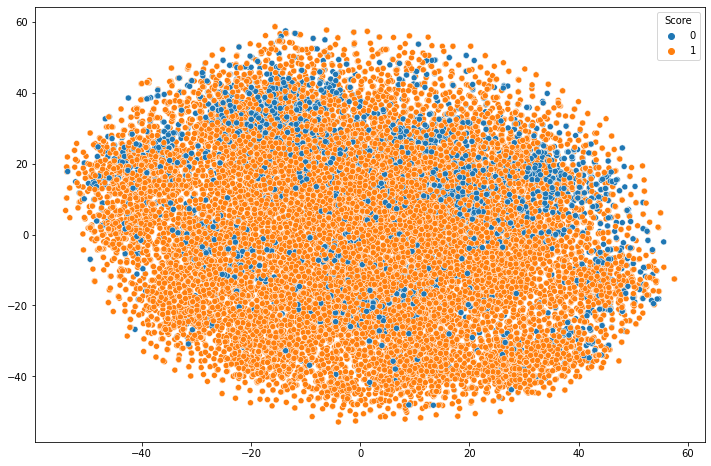

In [ ]:
#T-SNE on SVD data
tsne = TSNE()
X_tsne_emb = tsne.fit_transform(X_svd)
plt.figure(figsize=(12, 8))
sns.scatterplot(X_tsne_emb[:, 0], X_tsne_emb[:, 1], hue = y, legend = 'full')

### T-SNE on Bi-gram (Binary)

In [ ]:
#Truncated SVM
svd = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 1)
svd.fit(X_bi_binary)
X_svd = svd.transform(X_bi_binary)
print(svd.explained_variance_ratio_.sum())

0.36732034958907006


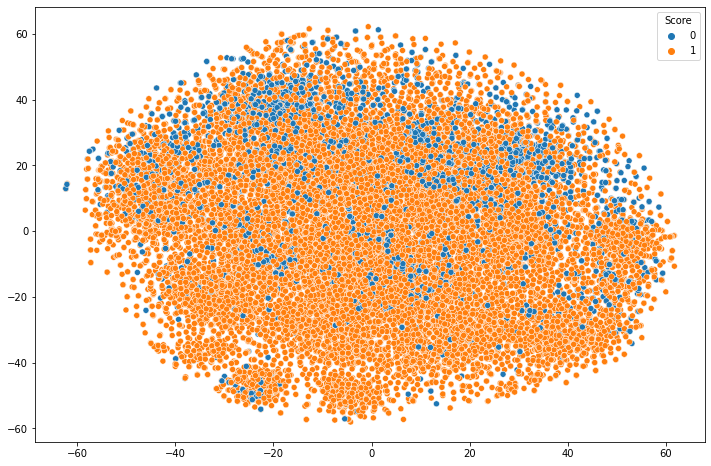

In [ ]:
#T-SNE on SVD data
tsne = TSNE()
X_tsne_emb = tsne.fit_transform(X_svd)
plt.figure(figsize=(12, 8))
sns.scatterplot(X_tsne_emb[:, 0], X_tsne_emb[:, 1], hue = y, legend = 'full')

### T-SNE on Uni-gram (Count)

In [ ]:
#Truncated SVM
svd = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 1)
svd.fit(X_uni)
X_svd = svd.transform(X_uni)
print(svd.explained_variance_ratio_.sum())

0.5207044055172583


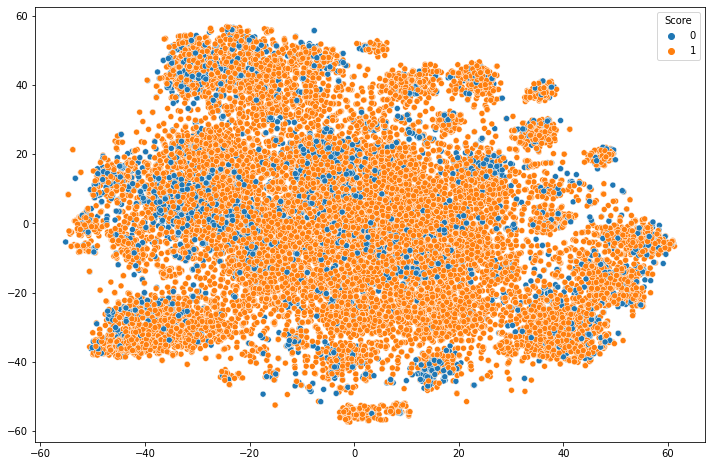

In [ ]:
#T-SNE on SVD data
tsne = TSNE()
X_tsne_emb = tsne.fit_transform(X_svd)
plt.figure(figsize=(12, 8))
sns.scatterplot(X_tsne_emb[:, 0], X_tsne_emb[:, 1], hue = y, legend = 'full')

### T-SNE on Bi-gram (Count)

In [ ]:
#Truncated SVM
svd = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 1)
svd.fit(X_bi)
X_svd = svd.transform(X_bi)
print(svd.explained_variance_ratio_.sum())

0.5127312475473166


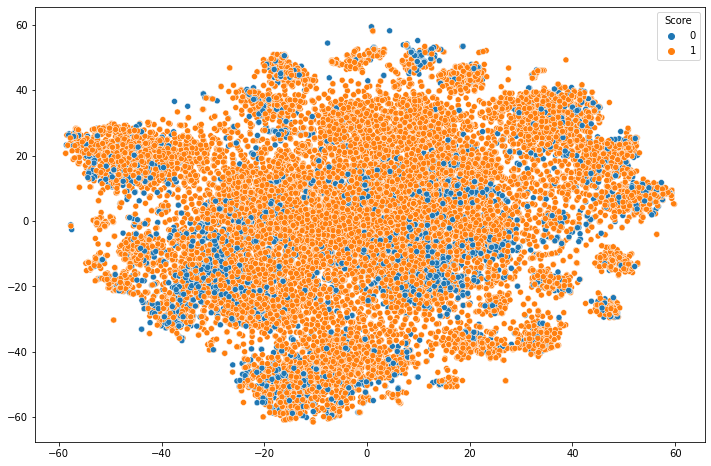

In [ ]:
#T-SNE on SVD data
tsne = TSNE()
X_tsne_emb = tsne.fit_transform(X_svd)
plt.figure(figsize=(12, 8))
sns.scatterplot(X_tsne_emb[:, 0], X_tsne_emb[:, 1], hue = y, legend = 'full')

## T-SNE on tf-idf

In [ ]:
#Truncated SVM
svd = TruncatedSVD(n_components = 100, n_iter = 100, random_state = 1)
svd.fit(X_tf_idf)
X_svd = svd.transform(X_tf_idf)
print(svd.explained_variance_ratio_.sum())

0.26892999575909504


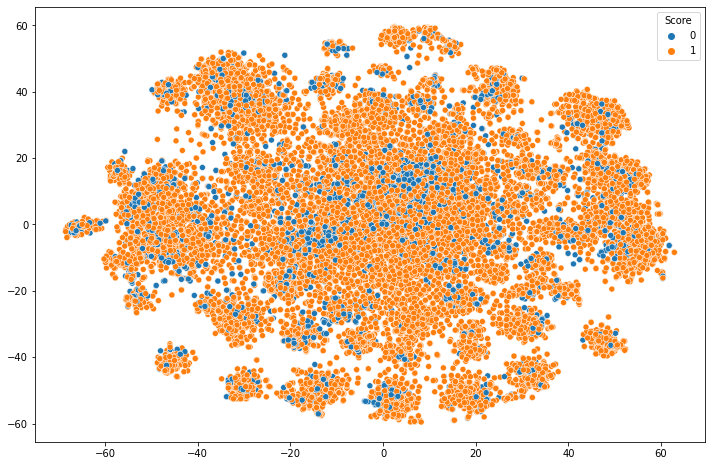

In [ ]:
#T-SNE on SVD data
tsne = TSNE()
X_tsne_emb = tsne.fit_transform(X_svd)
plt.figure(figsize=(12, 8))
sns.scatterplot(X_tsne_emb[:, 0], X_tsne_emb[:, 1], hue = y, legend = 'full')